### Dacon 소설작가 분류 
https://dacon.io/competitions/official/235670/overview/<br>
문장을 보고 어떤 소설작가가 작성했는지를 분류하는 문제<br>
Using LSTM 

In [1]:
import pandas as pd
import numpy as np
from time import time
from tqdm import tqdm
import re

In [2]:
import seaborn as sns

In [3]:
from nltk.tokenize import word_tokenize 
from gensim.models.word2vec import Word2Vec

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer

### Import data

In [6]:
train = pd.read_csv("train.csv")

In [7]:
test = pd.read_csv("test_x.csv")

In [8]:
ssb = pd.read_csv("sample_submission.csv")

### Tokenize
느낌표와 따옴표 등은 작가에따라 출현빈도가 달라질수있으니 ',', '.'만 stopwords로 지정한다

In [9]:
print('1번 : ', re.findall(r'[^a-zA-Z\s]',train[train['author']==1]['text'].iloc[0]))
print('2번 : ', re.findall(r'[^a-zA-Z\s]',train[train['author']==2]['text'].iloc[0]))

1번 :  [',', '’', ',', ',', ',', '.', ',', '.', ',', ':']
2번 :  ['“', ',', '?', '”']


In [10]:
stopWords = ['.',','] #문체 등을 확인할 수 있으므로 아주 의미없는것들만 stopwords로 지정

In [11]:
def tokenizeSentence(sentence):
    global stopWords
    return [x.lower() for x in word_tokenize(sentence) if x not in stopWords]

In [12]:
start = time()
n=1000
train[:n].apply(lambda x:tokenizeSentence(x['text']), axis=1)
print(f"If rows = {n}, spending time : ", time()- start)

If rows = 1000, spending time :  0.35771751403808594


In [14]:
train['word_list'] = train.apply(lambda x:tokenizeSentence(x['text']), axis=1)

In [15]:
test['word_list'] = test.apply(lambda x:tokenizeSentence(x['text']), axis=1)

### Word to vector using skip gram method
reference : [blog](http://doc.mindscale.kr/km/unstructured/11.html)

In [ ]:
words_test = []
for i in tqdm(test['word_list']):
    words_test.append(i)

In [ ]:
words = []

In [ ]:
for i in tqdm(train['word_list']):
    words.append(i)

In [14]:
len(words)

54879

In [68]:
model = Word2Vec(words[:5000],         # 리스트 형태의 데이터
                 sg=1,         # 0: CBOW, 1: Skip-gram
                 size=100,     # 벡터 크기
                 window=5,     # 고려할 앞뒤 폭(앞뒤 3단어)
                 iter=10,
                 min_count=5,  # 사용할 단어의 최소 빈도(5회 이하 단어 무시)
                 workers=4)    # 동시에 처리할 작업 수(코어 수와 비슷하게 설정)

In [69]:
model.wv.similarity('she', 'he') #코사인 유사도

0.6340599

In [1]:
#model.wv.vectors[0]

In [74]:
model.wv.most_similar('prince') #he와 가장 유사한 단어들

[('clerk', 0.7633887529373169),
 ('ivan', 0.7338625192642212),
 ('irritably', 0.7312246561050415),
 ('clara', 0.7298715114593506),
 ('considering', 0.7286543250083923),
 ('countess', 0.7274818420410156),
 ('joe', 0.725533127784729),
 ('guest', 0.7245358824729919),
 ('shrieked', 0.7235351800918579),
 ('smiling', 0.722305178642273)]

### EDA

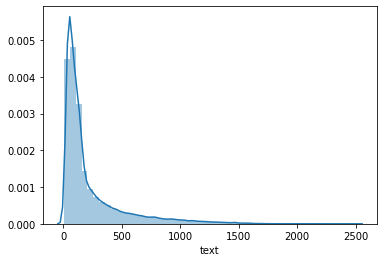

In [42]:
#문자 개수
sns.distplot(train['text'].str.len())

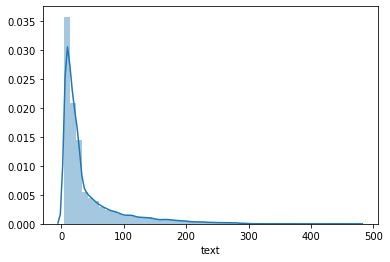

In [43]:
#단어 개수(rough)
sns.distplot(train['text'].str.split(' ').str.len())

In [13]:
#y 개수
len(train['author'].unique())

5

In [54]:
train['word_num'] = train['text'].str.split(' ').str.len()
train['letter_num'] = train['text'].str.len()

In [55]:
train.groupby('author').mean()['word_num']

author
0    37.417983
1    57.352949
2    40.344383
3    41.065326
4    41.626650
Name: word_num, dtype: float64

In [56]:
train.groupby('author').mean()['letter_num']

author
0    202.259312
1    313.824564
2    214.370521
3    223.593374
4    221.727995
Name: letter_num, dtype: float64

### Modeling

In [16]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train['word_list'])

In [17]:
tokened = tokenizer.texts_to_sequences(train['word_list'])

In [18]:
tokened_test = tokenizer.texts_to_sequences(test['word_list'])

In [19]:
# Getting the biggest sentence
max_len = np.max([len(text) for text in tokened])
# Creating the padded matrices

In [20]:
X_train_NN = pad_sequences(tokened, maxlen=max_len)

In [21]:
X_test_NN = pad_sequences(tokened_test, maxlen=max_len)

In [23]:
iDim = np.max([max(text) for text in tokened])+1

In [24]:


model = Sequential()
model.add(Embedding(
  input_dim=iDim, 
  output_dim=96, 
  input_length=max_len))

#model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))
model.add(tf.keras.layers.LSTM(64, dropout=0.2))
#model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(5, activation = 'softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [25]:
model.fit(X_train_NN,  train['author'],epochs=7, batch_size=128)

Epoch 1/7
429/429 [==============================] - 199s 463ms/step - loss: 1.0614 - accuracy: 0.5828
Epoch 2/7
429/429 [==============================] - 199s 465ms/step - loss: 0.5771 - accuracy: 0.7933
Epoch 3/7
429/429 [==============================] - 200s 466ms/step - loss: 0.4026 - accuracy: 0.8597
Epoch 4/7
429/429 [==============================] - 200s 466ms/step - loss: 0.3296 - accuracy: 0.8847
Epoch 5/7
429/429 [==============================] - 200s 466ms/step - loss: 0.2739 - accuracy: 0.9049
Epoch 6/7
429/429 [==============================] - 201s 469ms/step - loss: 0.2378 - accuracy: 0.9172
Epoch 7/7
429/429 [==============================] - 201s 467ms/step - loss: 0.2211 - accuracy: 0.9225


In [67]:
#y = pd.get_dummies(train['author']).values

In [86]:
model.fit(X_train_NN,  train['author'],epochs=5, batch_size=100)

Epoch 1/5
549/549 [==============================] - 264s 481ms/step - loss: 1.0113 - accuracy: 0.6028
Epoch 2/5
549/549 [==============================] - 265s 483ms/step - loss: 0.5759 - accuracy: 0.7926
Epoch 3/5
549/549 [==============================] - 268s 488ms/step - loss: 0.4265 - accuracy: 0.8514
Epoch 4/5
549/549 [==============================] - 280s 510ms/step - loss: 0.3108 - accuracy: 0.8923
Epoch 5/5
549/549 [==============================] - 262s 477ms/step - loss: 0.2607 - accuracy: 0.9106


In [26]:
pred = model.predict(X_test_NN)

In [27]:
submission = pd.DataFrame(pred)

In [28]:
submission=submission.reset_index()

In [29]:
submission.to_csv('submission2.csv',index=False)

In [30]:
submission

,index,0,1,2,3,4
0,0,0.000948,0.997066,0.000335,0.000078,0.001573
1,1,0.000605,0.996049,0.000153,0.003069,0.000124
2,2,0.999353,0.000176,0.000049,0.000015,0.000407
3,3,0.052059,0.110097,0.488082,0.002961,0.346801
4,4,0.071352,0.014820,0.052126,0.837394,0.024309
...,...,...,...,...,...,...
19612,19612,0.000499,0.998264,0.001012,0.000058,0.000168
19613,19613,0.002573,0.001239,0.000189,0.000416,0.995583
19614,19614,0.000642,0.998745,0.000322,0.000116,0.000175
19615,19615,0.000006,0.999986,0.000002,0.000001,0.000004
